# Import

In [1]:
!pip install tushare

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1272 sha256=784f292894e0ec285fbe90a1f9f18fecdc7c5b03bfde3c802b7890a067178265
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built bs4
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.5.1
    Uninstalling websocket-client-1.5.1:
      Successfully uninstalled websocket-client-1.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kfp 1.8.20 requires google-api-python-client<2,>=1.7.8, but you have google-api-python-client 2.86.0 which is incompatible.
kfp 1.8.20 requires PyYAM

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tushare as ts
import numpy as np
import matplotlib.pyplot as plt
import optuna
import warnings
warnings.filterwarnings("ignore")

from scipy.optimize import minimize
from scipy.stats import norm
from scipy.optimize import linprog
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf

# Download Data

In [3]:
#启用接口
pro=ts.pro_api('c07f4701cbb05cf7a9d93485be15cc93796552a2eb9dfbfa82a09b67')

# 定义参数
train_start_date = '20200101'
train_end_date = '20221231'

test_start_date = '20230101'
test_end_date = '20230512'

# 定义ts_code列表
ts_code_list = ['601318.SH', '600036.SH', '000651.SZ', '002594.SZ', '601888.SH']
df_train = pd.DataFrame()
df_test = pd.DataFrame()

# 遍历ts_code列表，获取每个股票的日线行情数据，并将其保存为CSV文件
for ts_code in ts_code_list:
    df_pretrain = pro.daily(ts_code=ts_code, adj='qfq', start_date=train_start_date, end_date=train_end_date)
    #file_name = ts_code + '.csv'
    df_train=pd.concat([df_train,df_pretrain['close']],axis=1)
    #df_train.to_csv(file_name, index=False)

df_train.columns = ['600036.SH', '601318.SH', '000651.SZ', '002594.SZ', '601888.SH']

for ts_code in ts_code_list:
    df_pretest = pro.daily(ts_code=ts_code, adj='qfq', start_date=test_start_date, end_date=test_end_date)
    #file_name = ts_code + '.csv'
    df_test=pd.concat([df_test,df_pretest['close']],axis=1)

df_test.columns = ['600036.SH', '601318.SH', '000651.SZ', '002594.SZ', '601888.SH']

In [4]:
df_train.to_csv('/kaggle/working/risk_train.csv', index=False)
df_test.to_csv('/kaggle/working/risk_test.csv', index=False)

# Basic Calculation

In [5]:
def log_return (df):
    df = df.apply(lambda x: np.log(x/x.shift(1)))
    df.dropna(inplace=True)
    return df

def excess_return (df):
    excess_cal = df.sub(df.mean())
    return excess_cal

def mean (df):
    mean_vec = np.array(df.mean(numeric_only=True))
    return mean_vec

def cov (df):
    cov_m = df.cov(numeric_only=True).astype(float)
    return cov_m

# Backtest

In [6]:
def backtest_portfolio(data, weights):
    # 转换数据格式，将日期作为索引，调整为逐日收益率
    returns = data.pct_change()

    # 计算组合收益率
    portfolio_returns = (returns * weights).sum(axis=1)
    #print(portfolio_returns.shape)

    # 计算累计收益率
    cumulative_returns = (1 + portfolio_returns).cumprod()

    # 计算IC
    benchmark_returns = returns.mean(axis=1)
    #print(benchmark_returns.shape)
    residuals = portfolio_returns - benchmark_returns
    IC = np.mean(residuals)

    # 计算ICIR
    ICIR = IC / np.std(residuals)

    # 计算Rank IC
    rank_IC = np.corrcoef(portfolio_returns.rank(), benchmark_returns.rank())[0, 1]

    # 计算Rank ICIR
    rank_ICIR = rank_IC / np.std(residuals)

    # 计算AR
    start_value = 1
    end_value = cumulative_returns.iloc[-1]
    num_periods = len(portfolio_returns)
    AR = (end_value / start_value) ** (1 / (num_periods / 252)) - 1

    # 计算MDD
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    MDD = drawdown.min()

    # 打印回测结果
    print("Cumulative Returns:", cumulative_returns.iloc[-1])
    print("Annual Returns:", AR)
    print("IC:", IC)
    print("ICIR:", ICIR)
    #print("Rank IC:", rank_IC)
    #print("Rank ICIR:", rank_ICIR)
    print("Max Drawdown:", MDD)

    # 绘制回测期间收益和累计收益曲线
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(portfolio_returns, label='Returns')
    ax[0].set_ylabel('Returns')
    ax[0].legend(loc='upper left')

    ax[1].plot(cumulative_returns, label='Cumulative Returns', color='r')
    ax[1].set_ylabel('Cumulative Returns')

    plt.show()

    # 返回累计收益（方便画图）
    return cumulative_returns.to_numpy()

# ARIMA

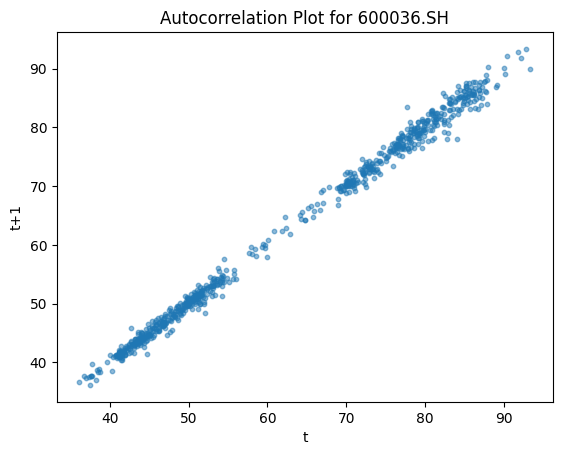

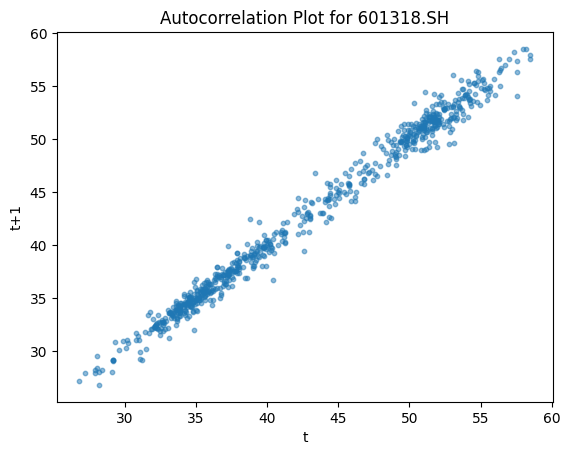

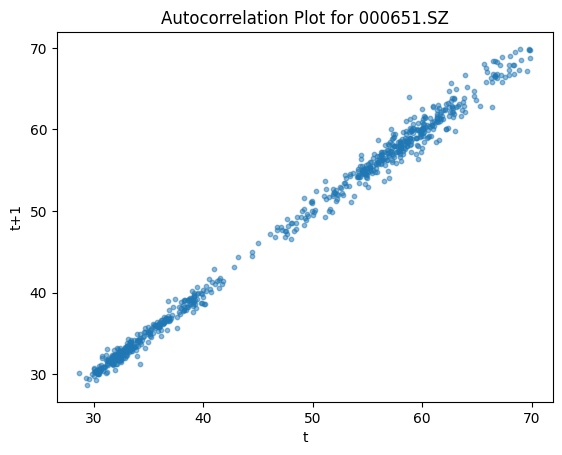

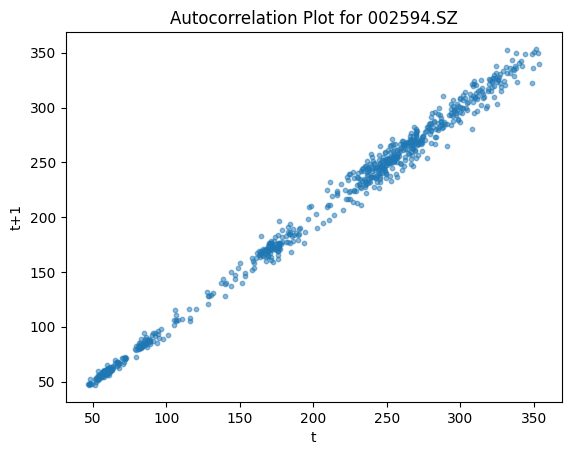

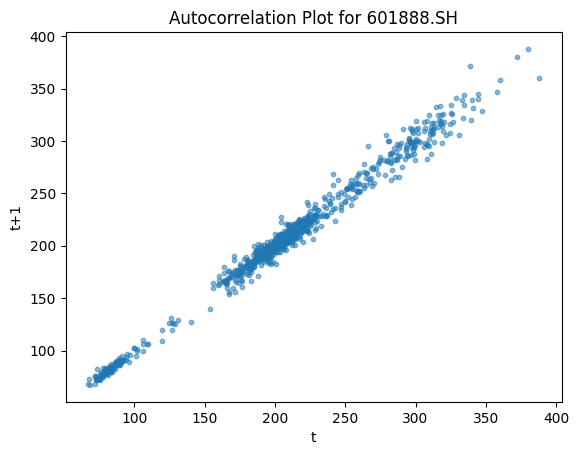

In [7]:
# 遍历每一列数据绘制散点图
for column in df_train.columns:
    x = df_train[column].values[:-1]  # t时刻的数据
    y = df_train[column].values[1:]   # t+1时刻的数据
    
    plt.scatter(x, y, marker='o', s=10, alpha=0.5)
    plt.xlabel('t')
    plt.ylabel('t+1')
    plt.title(f'Autocorrelation Plot for {column}')
    plt.show()

## Fitting test

In [8]:
def calculate_metrics(df_pre, df_test, ts_code_list):
    # 创建一个空的 DataFrame 用于存储拟合指标
    df_metrics = pd.DataFrame(index=ts_code_list, columns=['MSE', 'RMSE', 'MAE'])

    # 遍历每只股票计算拟合指标
    for ts_code in ts_code_list:
        # 提取当前股票的预测结果和实际测试数据
        predictions = df_pre[ts_code]
        actuals = df_test[ts_code]

        # 计算均方误差（MSE）
        mse = np.mean((predictions - actuals) ** 2)

        # 计算均方根误差（RMSE）
        rmse = np.sqrt(mse)

        # 计算平均绝对误差（MAE）
        mae = np.mean(np.abs(predictions - actuals))

        # 将拟合指标存储到 df_metrics 中
        df_metrics.loc[ts_code] = [mse, rmse, mae]

    return df_metrics

In [9]:
def compare_pre (df_actual,df_pre_fix, df_pre_rol, name):
    for ts_code in ts_code_list:
        plt.plot(df_actual[ts_code], label='Actual', color='grey')
        plt.plot(df_pre_fix[ts_code], label='Predicted_fix', color='blue')
        plt.plot(df_pre_rol[ts_code], label='Predicted_rol', color='red')
        plt.xlabel('Time')
        plt.ylabel('Returns')
        plt.title(f'{name} Predictions vs Actual - {ts_code}')
        plt.legend()
        plt.show()

## Fix ARIMA

In [10]:
# 创建一个空的 DataFrame 用于存储预测结果
df_pre_ARIMA_fix = pd.DataFrame()

# 定义ARIMA模型的阶数
p = 1  # AR阶数
d = 1  # 差分阶数
q = 1  # MA阶数

# 遍历每只股票进行预测
for ts_code in tqdm(ts_code_list):
    # 提取当前股票的数据
    endog = df_train[ts_code]
    actual_values = df_test[ts_code]
    
    # 训练ARIMA模型
    model = ARIMA(endog, order=(p, d, q))
    model_fit = model.fit()
    
    # 预测未来的收益率
    predictions = model_fit.predict(start=len(df_train), end=len(df_train) + len(df_test) - 1)
    
    # 将预测结果添加到 df_pre 中
    df_pre_ARIMA_fix[ts_code] = predictions
    
    
df_pre_ARIMA_fix.index = df_test.index

  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
 20%|██        | 1/5 [00:00<00:01,  3.93it/s]/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency info

## Rolling ARIMA

In [11]:
# 设置滑动窗口的大小和预测步长
window_size = 20  # 过去20天的数据
forecast_steps = 1  # 预测未来1天的数据

# 创建一个空的DataFrame用于存储迭代预测结果
df_pre_ARIMA = pd.DataFrame()

# 遍历每只股票进行迭代预测
for ts_code in tqdm(ts_code_list, desc='Predicting'):
    # 创建一个空的列表用于存储迭代预测结果
    predictions = []

    # 遍历每一天进行迭代预测
    for i in range(len(df_test)):
        # 提取当前窗口的数据
        endog = df_train[ts_code][i:i + window_size]

        # 训练ARIMA模型
        model = ARIMA(endog, order=(p, d, q))
        model_fit = model.fit()

        # 预测未来的收益率
        forecast = model_fit.forecast(forecast_steps)

        # 将预测结果添加到列表中
        predictions.append(pd.Series(forecast[0], index=[df_test.index[i]]))

        # 更新训练数据，加入当前的实际值
        df_train[ts_code][i + window_size] = df_test[ts_code][i]

    # 将列表中的预测结果合并为一个Series
    predictions = pd.concat(predictions)

    # 将预测结果添加到df_pre_ARIMA中
    df_pre_ARIMA[ts_code] = predictions

# 重新索引df_pre_ARIMA，使其与df_test的长度相同
df_pre_ARIMA = df_pre_ARIMA.iloc[:len(df_test)]

# 输出迭代预测结果
print(df_pre_ARIMA)

Predicting:   0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency N will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred

    601318.SH  600036.SH  000651.SZ   002594.SZ   601888.SH
0   36.025153  47.235355  32.951750  264.619011  205.887283
1   35.066573  49.980109  33.629299  260.282710  100.886946
2   34.748358  51.672619  33.777590  263.648666  143.888295
3   34.548507  52.752074  34.413346  259.595127  143.901291
4   34.808678  53.811093  34.642906  250.137141  148.295938
..        ...        ...        ...         ...         ...
80  37.951675  48.929157  34.279539  265.938910  232.440905
81  38.973461  50.658310  34.201384  262.592722  222.316372
82  38.299399  50.462015  34.207108  266.771026  226.236338
83  38.505878  48.821149  34.281978  264.872929  225.479918
84  38.685746  48.747938  33.477155  257.675449  210.742729

[85 rows x 5 columns]


## Rolling ARIMA's degree of fit is better

                    MSE        RMSE         MAE
601318.SH     10.215958    3.196241    2.662836
600036.SH   1413.272455   37.593516   37.511092
000651.SZ   1001.033503   31.639114   31.572224
002594.SZ  45541.591495   213.40476  212.811316
601888.SH  10899.857346  104.402382  101.850847
----------------------------------------------------
                 MSE      RMSE       MAE
601318.SH   0.417908  0.646458  0.524624
600036.SH   1.278669  1.130783  0.823731
000651.SZ   0.640201  0.800126  0.554222
002594.SZ  25.831256  5.082446  3.841549
601888.SH  88.291032  9.396331  4.185264
----------------------------------------------------


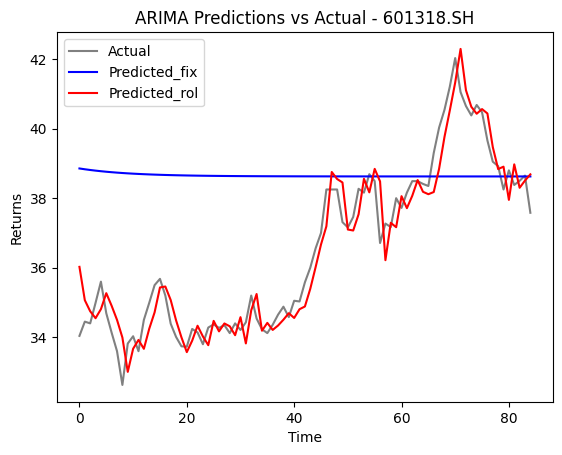

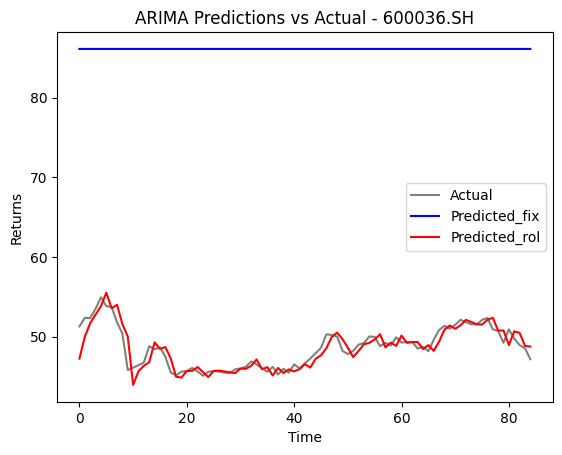

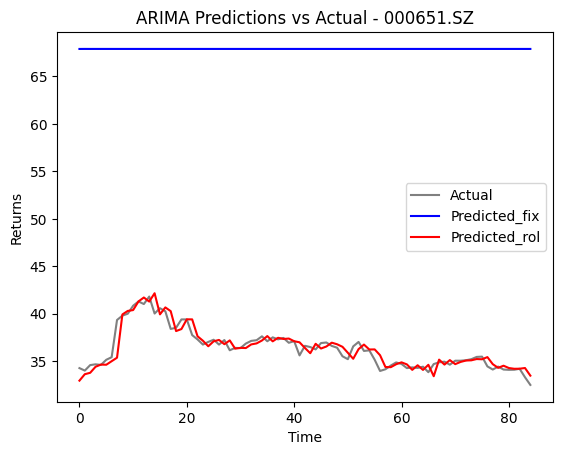

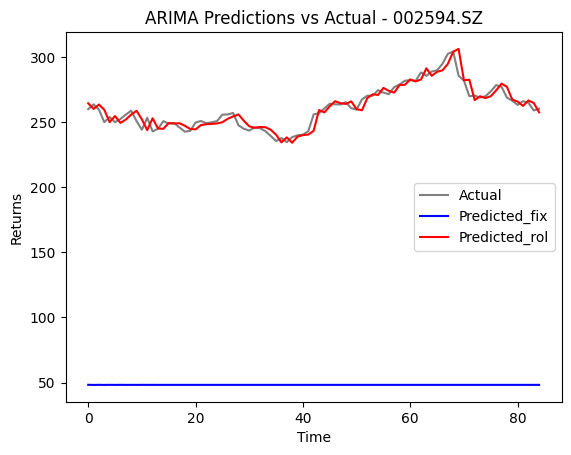

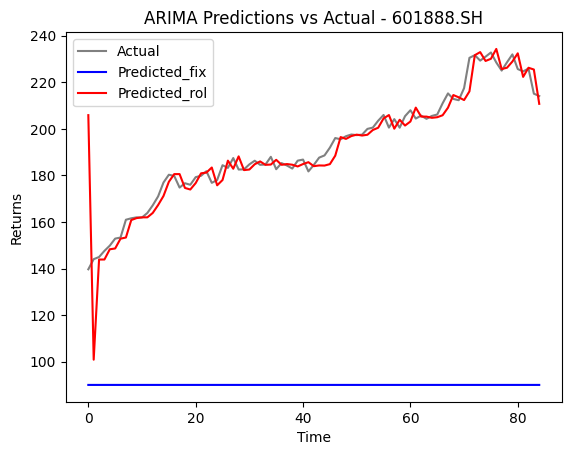

In [12]:
metrics_ARIMA_fix = calculate_metrics(df_pre_ARIMA_fix, df_test, ts_code_list)
print(metrics_ARIMA_fix)
print("----------------------------------------------------")
metrics_ARIMA = calculate_metrics(df_pre_ARIMA, df_test, ts_code_list)
print(metrics_ARIMA)
print("----------------------------------------------------")
compare_pre (df_test,df_pre_ARIMA_fix, df_pre_ARIMA, 'ARIMA')

# CVaR

In [13]:
def calculate_CVaR(w, scenarios, alpha=0.95):
    portfolio_returns = scenarios @ w
    VaR = np.percentile(portfolio_returns, (1 - alpha) * 100)
    CVaR = np.mean(portfolio_returns[portfolio_returns < VaR])
    return CVaR

def mean_CVaR_optimization(mu, scenarios, tau):
    n = len(mu)
    w = np.ones(n) / n

    def objective(w):
        return calculate_CVaR(w, scenarios)

    def constraint1(w):
        return w.T @ mu - tau

    def constraint2(w):
        return w.T @ np.ones(n) - 1
#不做空    
    def constraint3(w):
        return w-0

    cons = (
        {'type': 'ineq', 'fun': constraint1},
        {'type': 'eq', 'fun': constraint2},
        {'type': 'ineq', 'fun': constraint3}  #不做空
    )

    result = minimize(objective, w, constraints=cons, method='SLSQP')
    return result.x


def plot_mean_CVaR_efficient_frontier(mu, cov_matrix, scenarios, num_points=100):
    min_return = 0
    max_return = np.max(mu)
    target_returns = np.linspace(min_return, max_return, num_points)

    efficient_frontier_x = []
    efficient_frontier_y = []

    for tau in target_returns:
        w_opt = mean_CVaR_optimization(mu, scenarios, tau)
        portfolio_return = w_opt.T @ mu
        portfolio_std_dev = np.sqrt(w_opt.T @ cov_matrix @ w_opt)  # Calculate portfolio standard deviation

        efficient_frontier_x.append(portfolio_std_dev)
        efficient_frontier_y.append(portfolio_return)

    plt.scatter(efficient_frontier_x, efficient_frontier_y)
    plt.xlabel("Portfolio Standard Deviation")
    plt.ylabel("Portfolio Return")
    plt.title("Mean-CVaR Efficient Frontier")
    plt.show()

In [14]:
def generate_bootstrap_scenarios(historical_returns, num_scenarios):
    num_samples, num_assets = historical_returns.shape
    bootstrap_scenarios = np.zeros((num_scenarios, num_assets))

    for i in range(num_scenarios):
        random_indices = np.random.randint(0, num_samples, num_samples)
        bootstrap_scenario = historical_returns[random_indices].mean(axis=0)
        bootstrap_scenarios[i] = bootstrap_scenario

    return bootstrap_scenarios

## Fix ARIMA's backtest is better

[-8.71250294e-12  5.83474935e-12  9.61699432e-01  3.83005675e-02
  7.53291873e-12]
Cumulative Returns: 0.9512027288039064
Annual Returns: -0.13784352392198507
IC: -0.0015028796505664392
ICIR: -0.10260768856366728
Max Drawdown: -0.21283971446446437


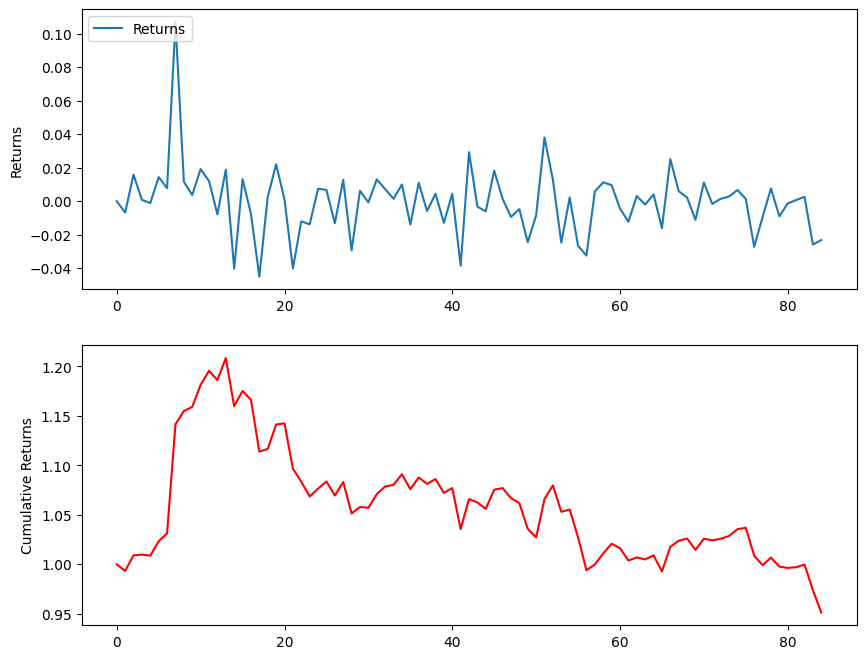

array([1.        , 0.99324124, 1.00895987, 1.00976412, 1.0086897 ,
       1.02322269, 1.03116536, 1.1414379 , 1.15479632, 1.15902414,
       1.18124649, 1.19546559, 1.18605294, 1.20839776, 1.15974568,
       1.17502486, 1.16619343, 1.11377395, 1.11655949, 1.14119277,
       1.14234743, 1.09654519, 1.08340728, 1.0684391 , 1.0764184 ,
       1.08366968, 1.06942117, 1.08304292, 1.05129624, 1.05785088,
       1.05706701, 1.07087365, 1.07860841, 1.08017811, 1.09099653,
       1.07580649, 1.0876494 , 1.0812471 , 1.08610428, 1.07211712,
       1.07694936, 1.03554043, 1.06589554, 1.06240324, 1.05598755,
       1.07531975, 1.07692601, 1.06682845, 1.06178118, 1.03582781,
       1.02698329, 1.06602747, 1.07964339, 1.05300307, 1.05533289,
       1.02724403, 0.9939154 , 0.99973134, 1.01098487, 1.02068621,
       1.01623072, 1.00377849, 1.00691446, 1.0048659 , 1.00897962,
       0.99275987, 1.01768151, 1.02376518, 1.02596263, 1.01453618,
       1.02585141, 1.02419055, 1.02565809, 1.02853146, 1.03541

In [15]:
# Fix ARIMA
df_ARIMA_fix = log_return (df_pre_ARIMA_fix)
excess_ARIMA_fix = excess_return(df_ARIMA_fix)
mean_vector_ARIMA_fix = mean (df_ARIMA_fix)
cov_matrix_ARIMA_fix = cov (excess_ARIMA_fix)
bootstrap_scenarios_ARIMA_fix = generate_bootstrap_scenarios(np.array(df_pre_ARIMA_fix), 10000)
ARIMA_CVaR_fix =  mean_CVaR_optimization(mean_vector_ARIMA_fix, bootstrap_scenarios_ARIMA_fix, 0)
print(ARIMA_CVaR_fix)
results_CVaR_ARIMA_fix = backtest_portfolio(df_test, ARIMA_CVaR_fix)
results_CVaR_ARIMA_fix

[ 1.00000000e+00 -2.21423561e-11 -2.53600877e-11  4.83057773e-11
  2.44059647e-11]
Cumulative Returns: 0.9196411156735661
Annual Returns: -0.21991990538684303
IC: -0.0019041174331355917
ICIR: -0.1328389868901959
Max Drawdown: -0.1791697013773819


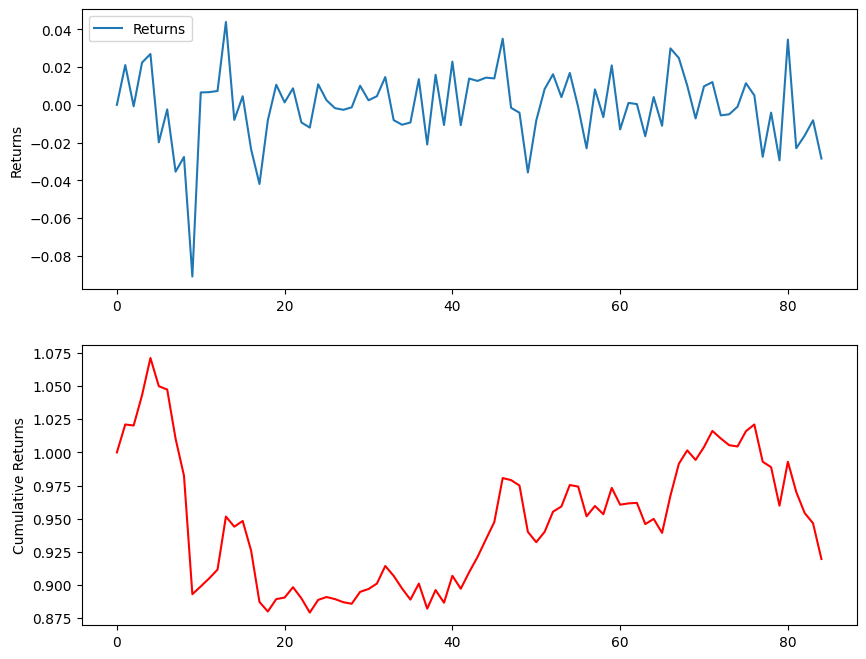

array([1.        , 1.02106495, 1.02028477, 1.04310513, 1.07119173,
       1.04993173, 1.04739614, 1.01033743, 0.98244587, 0.89311488,
       0.89896626, 0.90501268, 0.91164424, 0.95162863, 0.94402185,
       0.94831285, 0.92607763, 0.88726351, 0.88004681, 0.88940901,
       0.89057929, 0.89838112, 0.88999415, 0.87926663, 0.88882387,
       0.89096938, 0.88940901, 0.88706846, 0.88589819, 0.89487029,
       0.8970158 , 0.90111176, 0.91437488, 0.90696314, 0.89740589,
       0.88901892, 0.90111176, 0.88219232, 0.89623562, 0.88667837,
       0.90696314, 0.89721084, 0.90969378, 0.92120148, 0.9344646 ,
       0.94753267, 0.98069046, 0.9791301 , 0.97503413, 0.94012093,
       0.93231909, 0.94012093, 0.9553345 , 0.95923542, 0.97542422,
       0.97425395, 0.95182368, 0.95962551, 0.95338405, 0.97327872,
       0.96060074, 0.96157597, 0.96196606, 0.9459723 , 0.94987322,
       0.93934075, 0.96742735, 0.99141798, 1.00156037, 0.99434367,
       1.00409596, 1.0161888 , 1.01053248, 1.00546128, 1.00448

In [16]:
# ARIMA
df_ARIMA = log_return (df_pre_ARIMA)
excess_ARIMA = excess_return(df_ARIMA)
mean_vector_ARIMA = mean (df_ARIMA)
cov_matrix_ARIMA = cov (excess_ARIMA)

bootstrap_scenarios_ARIMA = generate_bootstrap_scenarios(np.array(df_pre_ARIMA), 10000)
ARIMA_CVaR =  mean_CVaR_optimization(mean_vector_ARIMA, bootstrap_scenarios_ARIMA, 0)
print(ARIMA_CVaR)

results_CVaR_ARIMA = backtest_portfolio(df_test, ARIMA_CVaR)
results_CVaR_ARIMA

# Accurate forecasting does not necessarily lead to better returns, which means that the CVaR model itself needs to be more robust.

## CRMC

In [17]:
def CRMC_optimization(mu, scenarios, tau, beta, lambda_val):
    n = len(mu)
    w = np.ones(n) / n

    def objective(w, beta):
        CVaR_max = calculate_CVaR(w, scenarios).max()
        CVaR_min = calculate_CVaR(w, scenarios).min()
        beta_scaled = (beta - 0) * (CVaR_max - CVaR_min) / (1 - 0) + CVaR_min
        return calculate_CVaR(w, scenarios) - lambda_val * (beta_scaled*0.1 + (1 / (1 - beta_scaled)) * np.mean(np.maximum(-scenarios @ w - beta_scaled*0.1, 0)))

    def constraint1(w):
        return w.T @ mu - tau

    def constraint2(w):
        return w.T @ np.ones(n) - 1
#不做空
    def constraint3(w):
        return w-0

    cons = (
        {'type': 'ineq', 'fun': constraint1},
        {'type': 'eq', 'fun': constraint2},
        {'type': 'ineq', 'fun': constraint3} #不做空
    )

    result = minimize(objective, w, beta, constraints=cons, method='SLSQP')
    optimized_weights = result.x
    optimized_weights[optimized_weights < 0] = 0  # 修正负数权重为零
    return optimized_weights

def plot_CRMC_efficient_frontier(mu, cov_matrix, scenarios, num_points=100, beta=0.7, lambda_val=0.3):
    min_return = 0
    max_return = np.max(mu)
    target_returns = np.linspace(min_return, max_return, num_points)

    efficient_frontier_x = []
    efficient_frontier_y = []

    for tau in target_returns:
        w_opt = CRMC_optimization(mu, scenarios, tau, beta, lambda_val)
        portfolio_return = w_opt.T @ mu
        portfolio_std_dev = np.sqrt(w_opt.T @ cov_matrix @ w_opt)  # Calculate portfolio standard deviation

        efficient_frontier_x.append(portfolio_std_dev)
        efficient_frontier_y.append(portfolio_return)

    plt.plot(efficient_frontier_x, efficient_frontier_y)
    plt.xlabel("Portfolio Standard Deviation")
    plt.ylabel("Portfolio Return")
    plt.title("CRMC Efficient Frontier")
    plt.show()

## Applying CRMC to future data: CRMC results outperform CVaR(fixARIMA) and CVaR(rollingARIMA)

[0.2 0.2 0.2 0.2 0.2]
Cumulative Returns: 1.0907072075802826
Annual Returns: 0.2935811310473102
IC: 8.970482260445542e-20
ICIR: 0.0664370749254103
Max Drawdown: -0.07505600788180611


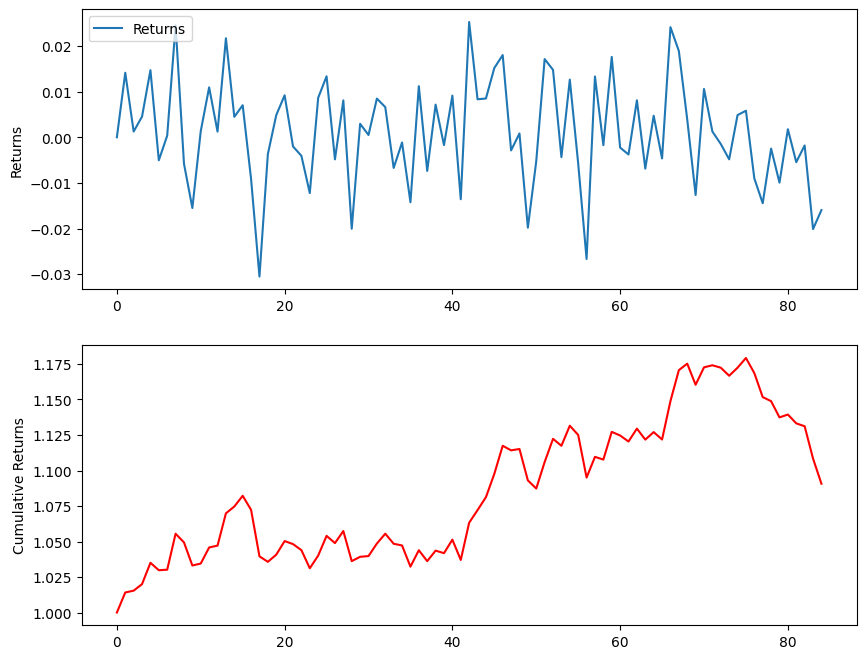

array([1.        , 1.0141388 , 1.0154126 , 1.02002465, 1.03502817,
       1.02980272, 1.03017319, 1.05550491, 1.04938906, 1.03311391,
       1.03451049, 1.04582915, 1.04712709, 1.06985917, 1.07465582,
       1.08220168, 1.0723025 , 1.03956558, 1.03571363, 1.04073761,
       1.05031581, 1.04819854, 1.04393433, 1.03117642, 1.04010011,
       1.05400485, 1.04890464, 1.05739186, 1.03618953, 1.0392511 ,
       1.03976928, 1.04858988, 1.05552709, 1.04843501, 1.04723037,
       1.03232135, 1.04388718, 1.03618729, 1.04360242, 1.04180761,
       1.05132236, 1.03704164, 1.06324629, 1.07209794, 1.08121573,
       1.09763627, 1.1174168 , 1.11420171, 1.11514143, 1.09304199,
       1.08731245, 1.10594961, 1.12229686, 1.11741045, 1.13153472,
       1.12503467, 1.09502298, 1.10961564, 1.1076976 , 1.12721188,
       1.12465764, 1.12042055, 1.12950834, 1.12175038, 1.12705554,
       1.12182799, 1.1489045 , 1.17063825, 1.17523094, 1.16035103,
       1.17263905, 1.17411064, 1.17238565, 1.16671747, 1.17239

In [18]:
ARIMA_CRMC = CRMC_optimization(mean_vector_ARIMA, bootstrap_scenarios_ARIMA, 0, beta=0.7, lambda_val=10)
print(ARIMA_CRMC) 
results_CRMC_ARIMA = backtest_portfolio(df_test, ARIMA_CRMC)
results_CRMC_ARIMA

## Applying CRMC to historical data: CRMC results outperform CVaR

In [19]:
df_train = log_return (df_train)
excess = excess_return(df_train)
mean_vector = mean (df_train)
cov_matrix = cov (excess)
bootstrap_scenarios = generate_bootstrap_scenarios(np.array(df_train), 10000)

Cumulative Returns: 1.0686815827883602
Annual Returns: 0.21766212832711873
IC: -0.00023847925848072092
ICIR: -0.13647238739885895
Max Drawdown: -0.07835602256654836


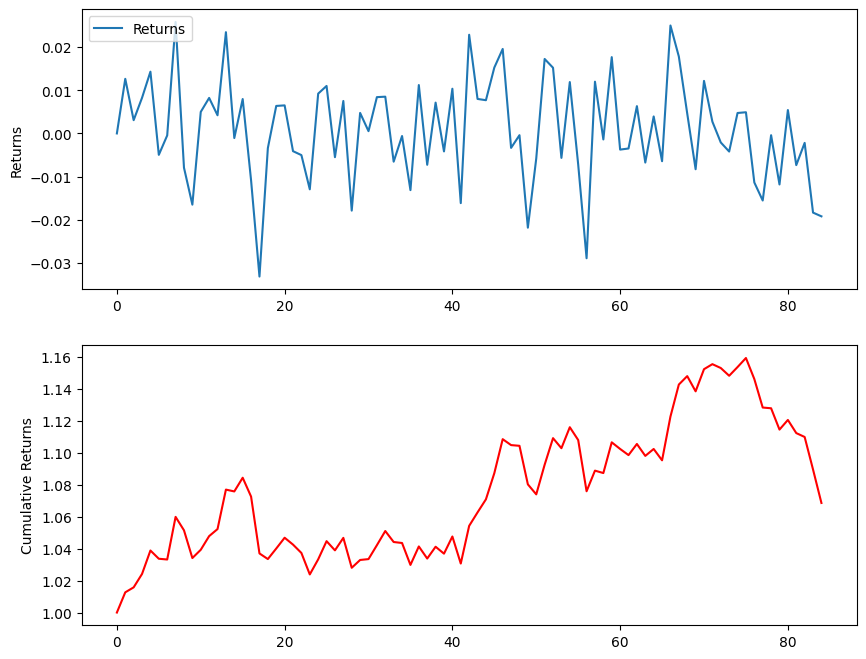

array([1.        , 1.01267707, 1.01579605, 1.0242023 , 1.03888416,
       1.03372023, 1.03324516, 1.05996961, 1.05154205, 1.03416441,
       1.03933651, 1.04790504, 1.05232306, 1.0770579 , 1.07590998,
       1.08449806, 1.0726857 , 1.0370541 , 1.03352436, 1.04012089,
       1.04689378, 1.04258527, 1.03734035, 1.02388856, 1.03334866,
       1.04473897, 1.03898363, 1.04680999, 1.02805908, 1.03295441,
       1.03350051, 1.04220849, 1.0511014 , 1.04421317, 1.04358991,
       1.02985961, 1.04142789, 1.0338506 , 1.04124616, 1.03690571,
       1.0476659 , 1.03071887, 1.05432726, 1.06277066, 1.07096801,
       1.08734081, 1.10866511, 1.10494951, 1.10450387, 1.08034388,
       1.07407708, 1.09264423, 1.10930415, 1.10301084, 1.11616268,
       1.10812262, 1.07602246, 1.08894824, 1.08742997, 1.10669031,
       1.10253855, 1.098685  , 1.10565394, 1.09818508, 1.10252078,
       1.095416  , 1.12285679, 1.14290293, 1.14818988, 1.13865093,
       1.15253338, 1.15567956, 1.15326087, 1.14841361, 1.15386

In [20]:
optimized_CVaR =  mean_CVaR_optimization(mean_vector,bootstrap_scenarios, 0)
results_CVaR = backtest_portfolio(df_test, optimized_CVaR)
results_CVaR

Cumulative Returns: 1.1610707829038005
Annual Returns: 0.5569940734226058
IC: 0.0007600392428280709
ICIR: 0.17245611514951933
Max Drawdown: -0.08158191692263432


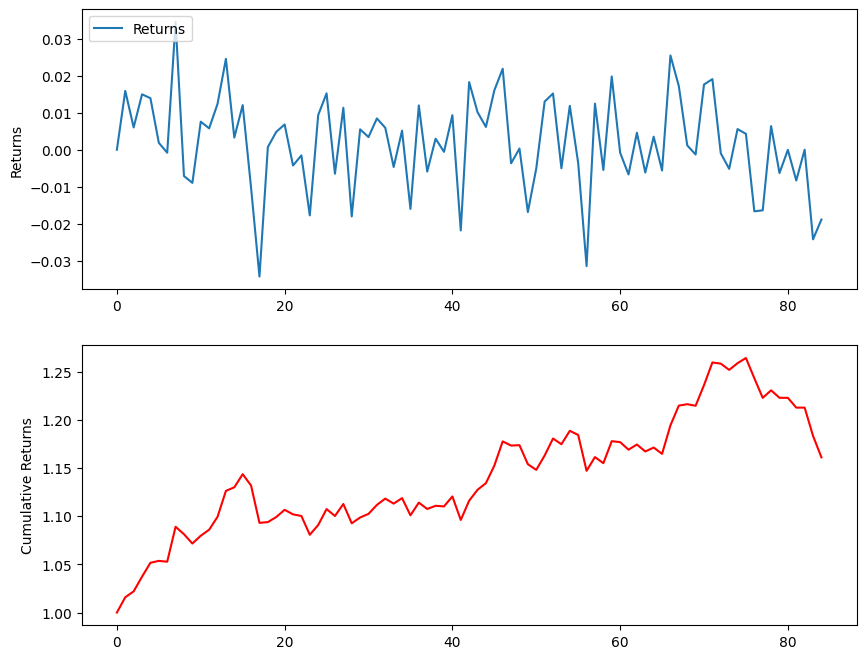

array([1.        , 1.01587655, 1.02197278, 1.03724554, 1.05166922,
       1.05362556, 1.05276581, 1.08904323, 1.08129866, 1.07162261,
       1.07972284, 1.08595778, 1.09936717, 1.12630991, 1.12999932,
       1.14360889, 1.13183462, 1.093095  , 1.09388236, 1.09914346,
       1.1066318 , 1.1019236 , 1.10023317, 1.08073845, 1.09082382,
       1.10740897, 1.10023153, 1.11268793, 1.09264775, 1.09865498,
       1.10240651, 1.11170575, 1.11828562, 1.11306715, 1.11878656,
       1.10092025, 1.11408042, 1.10750088, 1.11080524, 1.11017164,
       1.12051964, 1.09610953, 1.11610067, 1.12740969, 1.13433177,
       1.15247743, 1.17765066, 1.17332975, 1.17369708, 1.15396139,
       1.14809437, 1.16300345, 1.18064547, 1.1747259 , 1.188619  ,
       1.18431434, 1.1471141 , 1.161384  , 1.15502289, 1.17785265,
       1.17691176, 1.16905954, 1.17441916, 1.16718227, 1.17128421,
       1.16471525, 1.19433665, 1.21481719, 1.21624695, 1.21466484,
       1.23603234, 1.25957398, 1.25836387, 1.2518622 , 1.25883

In [21]:
optimized_CRMC = CRMC_optimization(mean_vector, bootstrap_scenarios, 0, beta=0.7, lambda_val=10)
results_CRMC = backtest_portfolio(df_test, optimized_CRMC)
results_CRMC

# Sliding window for position adjustment

## Sliding in future data

In [22]:
def cumulative_returns(data, weights):
    # 转换数据格式，将日期作为索引，调整为逐日收益率
    returns = data.pct_change()

    # 计算组合收益率
    portfolio_returns = (returns * weights).sum(axis=1)
    #print(portfolio_returns.shape)

    # 计算累计收益率
    cumulative_returns = (1 + portfolio_returns).cumprod()
    cumulative_returns = cumulative_returns.iloc[-1]
    print("Cumulative Returns:", cumulative_returns)
    
    return cumulative_returns

In [23]:
window_sizes = [5, 15, 20, 25, 30, 35, 40, 45]
best_window_size = None
best_cumulative_returns = float('-inf')

for window_size in window_sizes:
    # Initialize an empty DataFrame to store the optimized weights
    df_weights = pd.DataFrame(index=df_pre_ARIMA.index, columns=df_pre_ARIMA.columns)

    # Sliding window optimization
    for i in range(window_size, len(df_pre_ARIMA)):
        if (i - window_size) % window_size == 0:
            # Calculate mean vector, excess returns, and covariance matrix for the window
            window_data = df_pre_ARIMA.iloc[i-window_size:i]
            window_mean_vector = window_data.mean()
            window_excess_returns = window_data - window_mean_vector
            window_cov_matrix = window_excess_returns.cov()

            # Generate bootstrap scenarios for the window
            window_bootstrap_scenarios = generate_bootstrap_scenarios(window_data.values, 10000)

            # Perform mean-CRMC optimization for the window
            window_weights = CRMC_optimization(window_mean_vector, window_bootstrap_scenarios, 0, beta=0.7, lambda_val=10)

        # Assign the weights to the corresponding period in the DataFrame
        df_weights.iloc[i] = window_weights

    # Forward fill the weights to propagate them until the next adjustment
    df_weights = df_weights.ffill()

    # Fill the initial empty rows with historical values
    df_weights.iloc[:window_size] = np.tile(optimized_CRMC, (window_size, 1))

    # Calculate cumulative returns
    returns = cumulative_returns(df_test, df_weights)

    if returns > best_cumulative_returns:
        best_cumulative_returns = returns
        best_window_size = window_size

print("Best Window Size:", best_window_size)

Cumulative Returns: 1.1081894292575465
Cumulative Returns: 1.1471007126655863
Cumulative Returns: 1.152162208668978
Cumulative Returns: 1.1441806880158032
Cumulative Returns: 1.1533283135301493
Cumulative Returns: 1.1654951196036303
Cumulative Returns: 1.1625925896088163
Cumulative Returns: 1.1446048230664114
Best Window Size: 35


Cumulative Returns: 1.1654951196036303
Annual Returns: 0.5746496823603304
IC: 0.0007982167989805164
ICIR: 0.2843911896080973
Max Drawdown: -0.07505600788180568


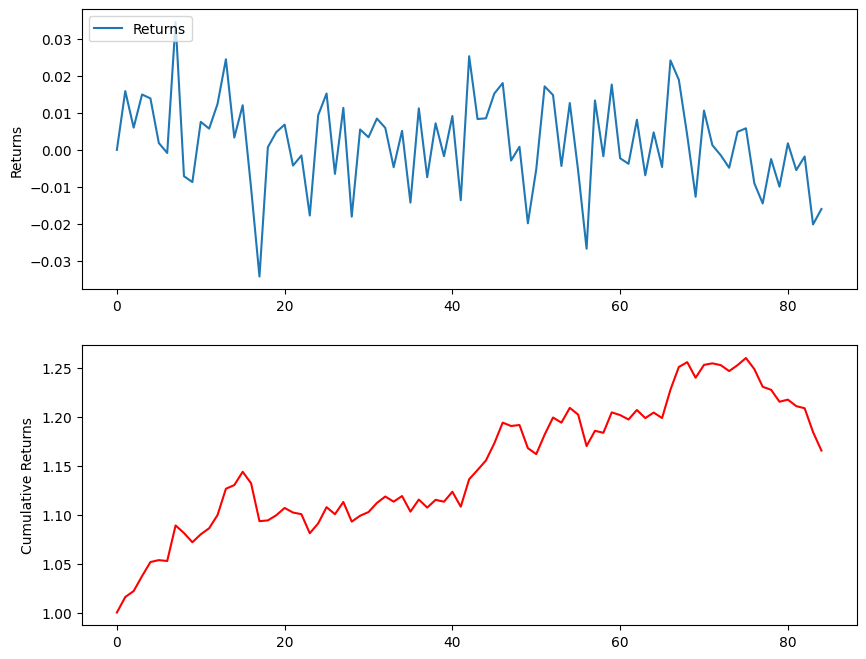

array([1.        , 1.01585828, 1.02195298, 1.03721465, 1.05161795,
       1.05356201, 1.05267301, 1.08898958, 1.0812426 , 1.07184615,
       1.07994733, 1.0861412 , 1.09959568, 1.12647794, 1.13021941,
       1.14383284, 1.13207942, 1.09337478, 1.09415588, 1.09937712,
       1.10686345, 1.10216853, 1.10049206, 1.08099742, 1.09109251,
       1.10768221, 1.10050039, 1.11297091, 1.09291351, 1.09891794,
       1.10265274, 1.11195822, 1.11855681, 1.11331295, 1.11903715,
       1.10310584, 1.11546472, 1.10723687, 1.11516043, 1.11324256,
       1.12340972, 1.1081498 , 1.13615126, 1.14560984, 1.15535283,
       1.17289929, 1.19403614, 1.1906006 , 1.19160476, 1.16799   ,
       1.16186759, 1.18178267, 1.19925082, 1.19402936, 1.20912211,
       1.20217635, 1.17010682, 1.18570007, 1.18365052, 1.20450285,
       1.20177347, 1.19724586, 1.20695678, 1.19866687, 1.2043358 ,
       1.1987498 , 1.2276829 , 1.2509069 , 1.2558145 , 1.2399143 ,
       1.25304489, 1.25461738, 1.25277411, 1.24671728, 1.25278

In [24]:
window_size = best_window_size  
num_stocks = 5  # Number of stocks

# Initialize an empty DataFrame to store the optimized weights
df_weights = pd.DataFrame(index=df_pre_ARIMA.index, columns=df_pre_ARIMA.columns)

# Sliding window optimization
for i in range(window_size, len(df_pre_ARIMA)):
    if (i - window_size) % window_size == 0:
        # Calculate mean vector, excess returns, and covariance matrix for the window
        window_data = df_pre_ARIMA.iloc[i-window_size:i]
        window_mean_vector = window_data.mean()
        window_excess_returns = window_data - window_mean_vector
        window_cov_matrix = window_excess_returns.cov()
        
        # Generate bootstrap scenarios for the window
        window_bootstrap_scenarios = generate_bootstrap_scenarios(window_data.values, 10000)
        
        # Perform mean-CRMC optimization for the window
        window_weights = CRMC_optimization(window_mean_vector, window_bootstrap_scenarios, 0, beta=0.7, lambda_val=10)
        
    # Assign the weights to the corresponding period in the DataFrame
    df_weights.iloc[i] = window_weights

# Forward fill the weights to propagate them until the next adjustment
df_weights = df_weights.ffill()

# Fill the initial empty rows with hitorical values
df_weights.iloc[:window_size] = np.tile(optimized_CRMC, (window_size, 1))

results_window_CRMC = backtest_portfolio(df_test, df_weights)
results_window_CRMC

# Summary

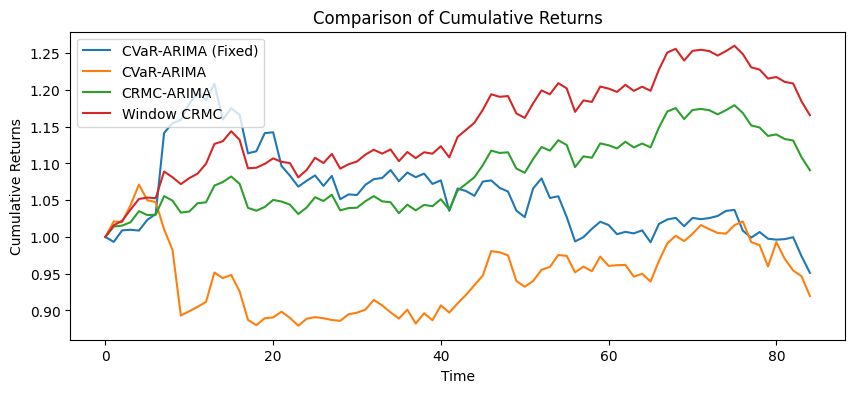

In [25]:
# 绘制折线图
plt.figure(figsize=(10, 4))
plt.plot(results_CVaR_ARIMA_fix, label='CVaR-ARIMA (Fixed)')
plt.plot(results_CVaR_ARIMA, label='CVaR-ARIMA')
plt.plot(results_CRMC_ARIMA, label='CRMC-ARIMA')
plt.plot(results_window_CRMC, label='Window CRMC')

# 添加图例
plt.legend()

# 添加标题和轴标签
plt.title('Comparison of Cumulative Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')

# 显示图形
plt.show()